<h1>NLP 10-K Statements<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-10-Ks" data-toc-modified-id="Download-10-Ks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download 10-Ks</a></span></li><li><span><a href="#Preprocess-10-Ks" data-toc-modified-id="Preprocess-10-Ks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocess 10-Ks</a></span></li><li><span><a href="#Analysis-on-10ks" data-toc-modified-id="Analysis-on-10ks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis on 10ks</a></span></li><li><span><a href="#Evaluating-The-Alpha-Factors" data-toc-modified-id="Evaluating-The-Alpha-Factors-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluating The Alpha Factors</a></span></li></ul></div>

This Project:
 - analyzes 10-K text data to generate sentiment-based alpha factors
 - the text-based stock selection model was originally described in the paper [Lazy Prices by Lauren Cohen et al](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1658471)
     - *"Changes to the language and construction of financial reports also have strong implications for firms’ future returns: a portfolio that shorts “changers” and buys “non-changers” earns up to 188 basis points in monthly alphas (over 22% per year) in the future. Changes in language referring to the executive (CEO and CFO) team, regarding litigation, or in the risk factor section of the documents are especially informative for future returns"*
 - downloads annual 10-k filings through SEC's website for a select set of companies, and extract key sections for sentiment analysis
---

**note:** uses end of day from Quotemedia and Loughran-McDonald sentiment word lists which could not be shared due to licensing restrictions

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import putils
import project_tests

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Download 10-Ks
---

**NLP Corpora**

the stopwords corpus for removing stopwords and wordnet for lemmatizing.

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**CIK lookup**

In [5]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

`SecAPI` class will cache data from the SEC and prevent going over the limit.

In [6]:
sec_api = putils.SecAPI()

In [7]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_data = pd.to_datetime('2018-01-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

**Ex. Fillings per company** prior to `2018-01-01`

In [8]:
example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm',
  '10-K',
  '2015-01-30'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872414000006/0001018724-14-000006-index.htm',
  '10-K',
  '2014-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000119312513028520/0001193125-13-028520-index.htm',
  '10-K',
  '2013-01-30')]


**Raw 10-k fillings**

In [9]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-17-000011.txt : 20170210
<SEC-HEADER>0001018724-17-000011.hdr.sgml : 20170210
<ACCEPTANCE-DATETIME>20170209175636
ACCESSION NUMBER:		0001018724-17-000011
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		92
CONFORMED PERIOD OF REPORT:	20161231
FILED AS OF DATE:		20170210
DATE AS OF CHANGE:		20170209

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		17588807

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<S

**Breaking up raw fillings into associated documents** - sectioned off using `<DOCUMENT>` - `</DOCUMENT>` tags, and extracting the documents

In [10]:
import re

def get_documents(text):
    """
    Extracts the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    extracted_docs = []
    for s,e,doc in zip(doc_start_is, doc_end_is, text):
        extracted_docs.append(text[s:e])
        
    return extracted_docs

In [11]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from HON Fillings: 100%|██████████| 20/20 [00:00<00:00, 46.66filling/s]

Document 0 Filed on 2017-02-10:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20161231x10k.htm
<DESCRIPTION>FORM 10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<he...

Document 1 Filed on 2017-02-10:

<TYPE>EX-12.1
<SEQUENCE>2
<FILENAME>amzn-20161231xex121.htm
<DESCRIPTION>COMPUTATION OF RATIO OF EARNINGS TO FIXED CHARGES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http:...

Document 2 Filed on 2017-02-10:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20161231xex211.htm
<DESCRIPTION>LIST OF SIGNIFICANT SUBSIDIARIES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/h...


**Filter out non 10-K documents with `<TYPE>` tag**

In [12]:
def get_document_type(doc):
    """
    Returns the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    doc_type = type_pattern.findall(doc)[0]
    
    return doc_type.lower()[len('<TYPE>'):]

With the `get_document_type` function, we'll filter out all non 10-k documents.

In [13]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


putils.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2015123...
    file_date: '2016-01-29'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2014123...
    file_date: '2015-01-30'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2013123...
    file_date: '2014-01-31'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d445434d10k....
    file_date: '2013-01-30'},
]


## Preprocess 10-Ks
---

In [14]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text

def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

In [15]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


putils.print_ten_k_data(ten_ks_by_ticker[example_ticker][:4], ['file_clean'])

Cleaning HON 10-Ks: 100%|██████████| 20/20 [00:56<00:00,  2.81s/10-K]

[
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20151231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20141231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20131231x10k.htm\nform 10-k\n\n\n...},
]


**Lemmatization**

In [16]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    lemmed = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]
    
    return lemmed

In [17]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


putils.print_ten_k_data(ten_ks_by_ticker[example_ticker][:4], ['file_lemma'])

Lemmatize HON 10-Ks: 100%|██████████| 20/20 [00:05<00:00,  3.4610-K/s]

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20141231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20131231x10k', 'htm', '...},
]


**Removing Stopwords**

In [18]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]

Remove Stop Words for HON 10-Ks: 100%|██████████| 20/20 [00:02<00:00,  7.6810-K/s]


## Analysis on 10ks
---

**Loughran McDonald Sentiment Word Lists**, the following will be used:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

In [19]:
import os

sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv(os.path.join('assets', 'loughran_mcdonald_master_dic_2016.csv'))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


**Bag of Words**: counts the number of sentiment words in each doc, ignoring words that are not in `sentiment_df`

In [20]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_bag_of_words(sentiment_words, docs):
    """
    Generates a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    bag_of_words = np.empty((0,len(sentiment_words)),int)

    vectorizer = CountVectorizer()

    vectorizer.fit(sentiment_words)

    vector = vectorizer.transform(docs).toarray()

    bag_of_words = np.append(bag_of_words, vector, axis=0)

    return bag_of_words

In [21]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


putils.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n [0 0 0...
    positive: '[[16  0  0 ...,  0  0  0]\n [16  0  0 ...,  0  0 ...
    uncertainty: '[[0 0 0 ..., 1 1 3]\n [0 0 0 ..., 1 1 3]\n [0 0 0...
    litigious: '[[0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n [0 0 0...
    constraining: '[[0 0 0 ..., 0 0 2]\n [0 0 0 ..., 0 0 2]\n [0 0 0...
    interesting: '[[2 0 0 ..., 0 0 0]\n [2 0 0 ..., 0 0 0]\n [2 0 0...},
]


**Jaccard Similarity**

Computes the similarity for each neighboring bag of words (i.e. each neighboring document) over time

$$
\text { Jaccard Similarity }=\frac{\sum_{i} \min \left\{u_{i}, v_{i}\right\}}{\sum_{i} \max \left\{u_{i}, v_{i}\right\}}
$$

In [22]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Returns jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    bow_bool = bag_of_words_matrix.astype(bool)
    jaccard_similarities = [jaccard_similarity_score(u,v) for u,v in zip(bow_bool, bow_bool[1:])]
    
    return jaccard_similarities

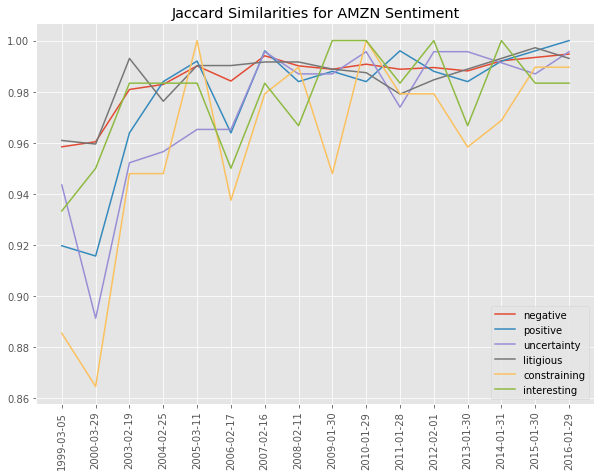

In [23]:
# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


putils.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

**TF-IDF** to calibrate word uniqueness ignoring words that are not in `sentiment_words`

$$
\text { tfidf }(t, d, D)=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
$$

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generates TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    vectorizer = TfidfVectorizer(vocabulary=sentiment_words)
    
    
    return vectorizer.fit_transform(docs).toarray()

In [25]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
putils.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[ 0.          0.          0.         ...,  0.   ...
    positive: '[[ 0.22288432  0.          0.         ...,  0.   ...
    uncertainty: '[[ 0.          0.          0.         ...,  0.005...
    litigious: '[[ 0.  0.  0. ...,  0.  0.  0.]\n [ 0.  0.  0. .....
    constraining: '[[ 0.          0.          0.         ...,  0.   ...
    interesting: '[[ 0.01673784  0.          0.         ...,  0.   ...},
]


**Cosine Similarity using the TFIDF values**

$$
\text { Cosine Similarity }=\cos \theta=\frac{u \cdot v}{|u||v|}
$$

In [26]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Returns cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    x,y = tfidf_matrix.shape
    cos_similarity = []
    for i in range(x-1):
        cos_similarity.append(cosine_similarity([tfidf_matrix[i],tfidf_matrix[i+1]])[0][1])
    return cos_similarity

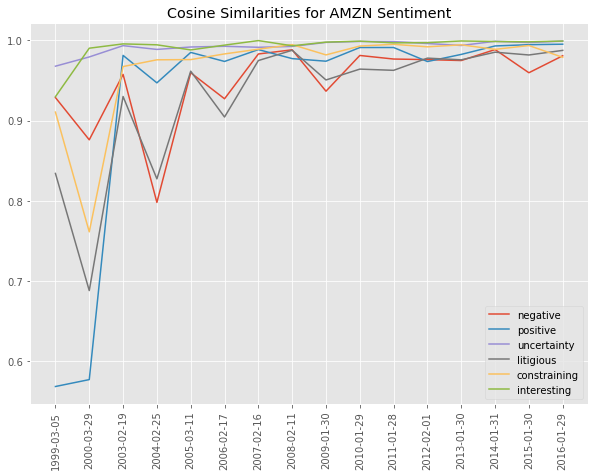

In [27]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


putils.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

## Evaluating The Alpha Factors
---

**Annual Pricing Data**

In [28]:
pricing = pd.read_csv('assets/yr-quotemedia.csv', parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')


pricing[-5:]

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,...,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,39.43238724,nan,nan,50.51000000,30.92000000,36.88899069,32.90504993,51.89970750,310.12000000,3.94778326,...,38.63000000,nan,nan,nan,1.43000000,nan,nan,nan,100.00000000,0.50000000
2015-01-01,40.79862571,nan,31.27000000,33.26000000,19.06000000,38.06921608,30.53000000,41.33893271,17.16000000,4.91270038,...,15.12000000,nan,nan,nan,0.79000000,14.10000000,nan,10.07000000,100.00000000,1.00000000
2016-01-01,44.93909238,28.08000000,26.76000000,38.67000000,7.24000000,39.81959334,nan,46.08991196,53.50000000,4.05320152,...,21.85000000,nan,100.01000000,14.26000000,1.19890000,8.00000000,nan,15.59000000,100.00000000,25.00000000
2017-01-01,66.65391782,53.87000000,81.62000000,69.85000000,9.00000000,58.83570736,nan,51.80358470,81.60000000,3.37888199,...,20.82500000,nan,100.10000000,nan,1.21650000,nan,7.59310000,12.52000000,25.00000000,0.01000000
2018-01-01,61.80000000,46.88000000,81.63000000,73.35000000,9.81000000,52.88000000,nan,37.99000000,67.90000000,2.57500000,...,24.30000000,26.74000000,nan,nan,1.38000000,nan,15.34000000,9.17000000,nan,nan


**Cosine Similarities DF**

In [29]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')


cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2016-01-01,AMZN,negative,0.98065125
1,2015-01-01,AMZN,negative,0.95951741
2,2014-01-01,AMZN,negative,0.98838551
3,2013-01-01,AMZN,negative,0.97472377
4,2012-01-01,AMZN,negative,0.97585100


**Factor Data**

In [30]:
import alphalens as al

factor_data = {}
skipped_sentiments = []

for sentiment in sentiments:
    cs_df = cosine_similarities_df[(cosine_similarities_df['sentiment'] == sentiment)]
    cs_df = cs_df.pivot(index='date', columns='ticker', values='value')
    
    try:
        data = al.utils.get_clean_factor_and_forward_returns(cs_df.stack(), pricing, quantiles=5, bins=None, periods=[1])
        factor_data[sentiment] = data
    except:
        skipped_sentiments.append(sentiment)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

1D     factor  factor_quantile
date       asset                                       
1994-01-01 BMY   0.53264104 0.44784189                1
           CVX   0.22211880 0.91363233                5
           FRT   0.17159556 0.47730392                3
1995-01-01 BMY   0.32152919 0.89403523                1
           CVX   0.28478156 0.91066582                3

unix factor data

In [31]:
unixt_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

**Factor Returns**

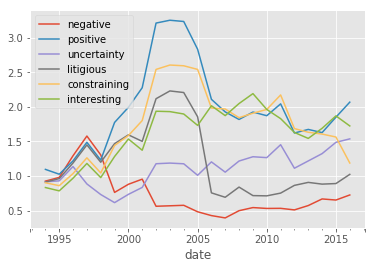

In [32]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

**Basis points per day per quantile**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe40ce85b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe40cf710f0>]], dtype=object)

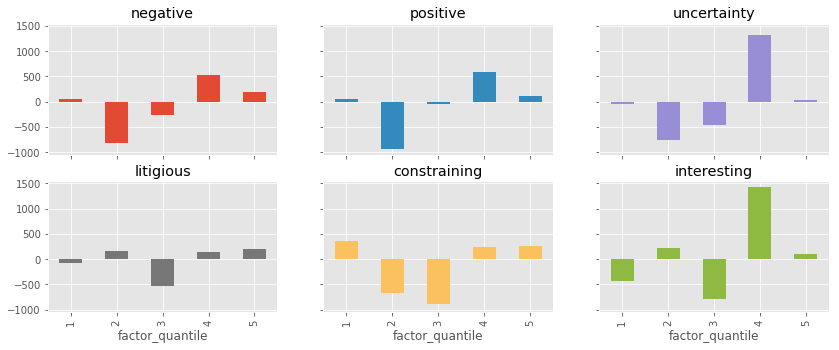

In [33]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

**FRA (Turnover Analysis)**

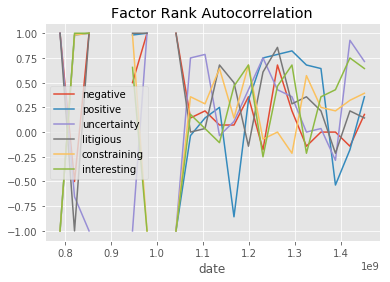

In [34]:
ls_FRA = pd.DataFrame()

for factor, data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

**Sharpe Ratios**

In [35]:
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

negative       0.39000000
positive       4.17000000
uncertainty    3.05000000
litigious      1.97000000
constraining   1.92000000
interesting    3.49000000
dtype: float64